In [6]:
import sys
sys.path.append('/opt/notebooks/polytrader')

In [7]:
from agents.polymarket.polymarket import Polymarket

In [8]:
p = Polymarket()

In [9]:
game = p.get_market_by_slug('nfl-phi-bal-2024-12-01')

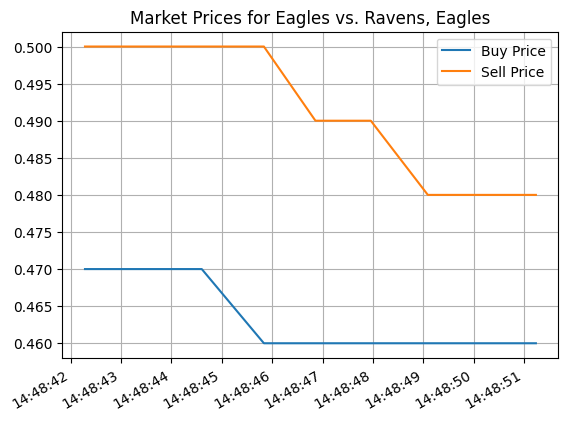

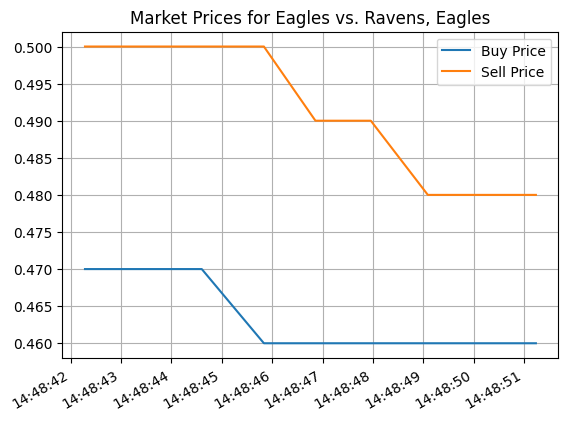

KeyboardInterrupt: 

KeyboardInterrupt: 

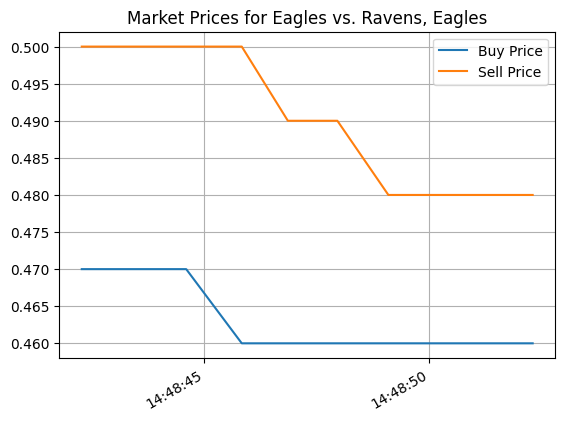

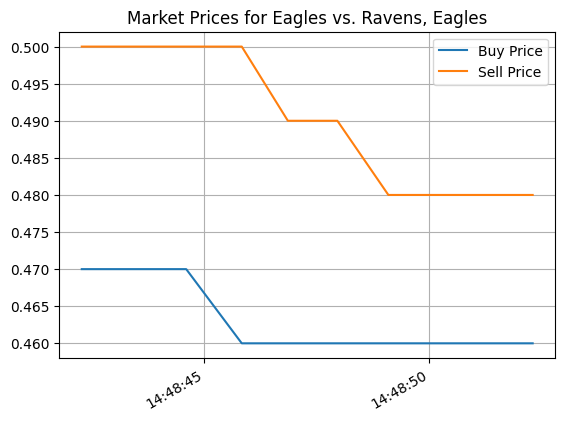

In [13]:
import time
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, clear_output

token = game.token1
buy_prices = []
sell_prices = []
times = []

while True:
    try:
        buy_price = float(p.client.get_price(token, side='buy')['price'])
        sell_price = float(p.client.get_price(token, side='sell')['price'])
        current_time = datetime.now()
        
        buy_prices.append(buy_price)
        sell_prices.append(sell_price)
        times.append(current_time)
        
        # Create new figure for each update
        fig, ax = plt.subplots()
        ax.plot(times, buy_prices, label='Buy Price')
        ax.plot(times, sell_prices, label='Sell Price')
        ax.legend()
        ax.grid(True)
        ax.set_title(f"Market Prices for {game.question}, Token: {eval(game.outcomes)[0]}")
        fig.autofmt_xdate()
        
        # Display the plot
        display(fig)
        clear_output(wait=True)
        
        plt.pause(0.5) # Wait 1 second between updates
        
    except Exception as e:
        print(f"Error: {e}")
        time.sleep(1)
        continue

In [ ]:
p.client.get_order_book(game.token1)